In [1]:
import os
import re


import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Define colors for modes
MODE_COLORS = {"Hard": "blue", "Soft": "orange"}
LINE_STYLES = ["-", "--", "-.", ":"]  # cycle for different exponents
SYMBOLS = ["o", "s", "^", "D"]  # cycle for different exponents
SYMBOL_COLORS = ["blue", "orange", "green", "red", "purple", "brown"]


def get_style(mode, exp):
    """
    Returns (color, linestyle) based on sim_dir.
    Hard = blue, Soft = red.
    linestyle determined by exponent.
    """

    # cycle if more than 4 exponents

    linestyle = LINE_STYLES[(-exp) % len(LINE_STYLES)]
    symbol = SYMBOLS[(-exp) % len(SYMBOLS)]
    symbol_color = SYMBOL_COLORS[(-exp) % len(SYMBOL_COLORS)]

    return MODE_COLORS[mode], linestyle, symbol, symbol_color



In [3]:
from load_combined import load_combined

sim_dirs = [
    "../data/20250929_144708/24ranks/89861/vtk_output_soft/",
    "../data/20250929_144708/48ranks/89862/vtk_output_soft/",
    "../data/20250929_144708/64ranks/89863/vtk_output_soft/",
    "../data/20250929_144708/96ranks/89864/vtk_output_soft/",
    "../data/20250929_144708/112ranks/89865/vtk_output_soft/",
]
particles_dict, sim_dict, params_dict = load_combined(sim_dirs)

loading ../data/20250929_144708/24ranks/89861/vtk_output_soft/
loading ../data/20250929_144708/48ranks/89862/vtk_output_soft/
loading ../data/20250929_144708/64ranks/89863/vtk_output_soft/
loading ../data/20250929_144708/96ranks/89864/vtk_output_soft/
loading ../data/20250929_144708/112ranks/89865/vtk_output_soft/


In [4]:
particles_dict[next(iter(particles_dict))].keys()

Index(['gid', 'quaternion_x', 'quaternion_y', 'quaternion_z', 'quaternion_w',
       'orientation_x', 'orientation_y', 'orientation_z', 'orientation_angle',
       'length', 'impedance', 'stress', 'number_of_constraints', 'age',
       'forces_x', 'forces_y', 'forces_z', 'velocity_linear_x',
       'velocity_linear_y', 'velocity_linear_z', 'velocity_angular_x',
       'velocity_angular_y', 'velocity_angular_z', 'rank', 'x', 'y', 'z'],
      dtype='object')

In [5]:
sim_dict[next(iter(sim_dict))].keys()

Index(['iteration', 'simulation_time_s', 'step_duration_s', 'step',
       'num_particles', 'num_constraints', 'colony_radius',
       'recursive_iterations', 'bbpgd_iterations', 'max_overlap', 'residual',
       'memory_usage_mb', 'peak_memory_mb', 'cpu_time_s', 'mpi_comm_time_s',
       'load_imbalance', 'dt_s', 'x', 'y', 'z', 'rank'],
      dtype='object')

In [6]:
params_dict[next(iter(sim_dict))].keys()

Index(['iteration', 'dt_s', 'end_radius', 'log_frequency_seconds',
       'min_box_size_x', 'min_box_size_y', 'min_box_size_z', 'xi', 'TAU', 'l0',
       'LAMBDA', 'temperature', 'kcc', 'max_bbpgd_iterations',
       'max_recursive_iterations', 'linked_cell_size', 'growth_factor',
       'particle_preallocation_factor', 'mode', 'x', 'y', 'z', 'rank'],
      dtype='object')

In [7]:

data = {}
data["Soft"] = {"ranks": [], "walltimes": []}
data["Hard"] = {"ranks": [], "walltimes": []}


ranks = []
walltimes = []

LAMBDA = None

for key, _ in particles_dict.items():
    particles = particles_dict[key]
    simulation = sim_dict[key]

    if LAMBDA is None:
        LAMBDA = key[1]
    else:
        if key[1] != LAMBDA:
            raise ValueError("Multiple LAMBDA values found!")

    ranks = particles["rank"].max() + 1
    walltime = simulation["cpu_time_s"].max()

    final_radius = np.sqrt(
        particles["x"].iloc[-1]**2 + particles["y"].iloc[-1]**2 + particles["z"].iloc[-1]**2)
    print(f"{key}: final radius = {final_radius:.2f}")

    data[key[0]]["ranks"].append(ranks)
    data[key[0]]["walltimes"].append(walltime)

('Soft', -2, '../data/20250929_144708/24ranks/89861/vtk_output_soft/assumed $\\lambda = 10^{-2}$'): final radius = 82.19
('Soft', -2, '../data/20250929_144708/48ranks/89862/vtk_output_soft/assumed $\\lambda = 10^{-2}$'): final radius = 71.20
('Soft', -2, '../data/20250929_144708/64ranks/89863/vtk_output_soft/assumed $\\lambda = 10^{-2}$'): final radius = 19.29
('Soft', -2, '../data/20250929_144708/96ranks/89864/vtk_output_soft/assumed $\\lambda = 10^{-2}$'): final radius = 39.10
('Soft', -2, '../data/20250929_144708/112ranks/89865/vtk_output_soft/assumed $\\lambda = 10^{-2}$'): final radius = 59.86


In [8]:
print(data)

{'Soft': {'ranks': [np.int64(24), np.int64(48), np.int64(64), np.int64(95), np.int64(105)], 'walltimes': [np.float64(29031.1), np.float64(7911.21), np.float64(7848.51), np.float64(5722.34), np.float64(3791.76)]}, 'Hard': {'ranks': [], 'walltimes': []}}


In [9]:
def plot_hard_scaling(data):
    fig, ax = plt.subplots(figsize=(10, 6))

    outname = f"hard_soft_scaling_lambda_{LAMBDA}.png"

    for mode, vals in data.items():
        color, linestyle, symbol, symbol_color = get_style(mode, LAMBDA)

        x_data, y_data = vals["ranks"], vals["walltimes"]

        label = f"{mode} ($\\lambda = 10^{{{LAMBDA}}}$)"

        ax.plot(x_data, y_data, symbol, ls=linestyle, color=color,
                linewidth=2,  label=label, markevery=0.1)

    ax.set_xlabel("Ranks", fontsize=20)
    ax.set_ylabel("Walltime", fontsize=20)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    ax.grid(True)
    ax.legend(fontsize=16)
    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")
    return fig

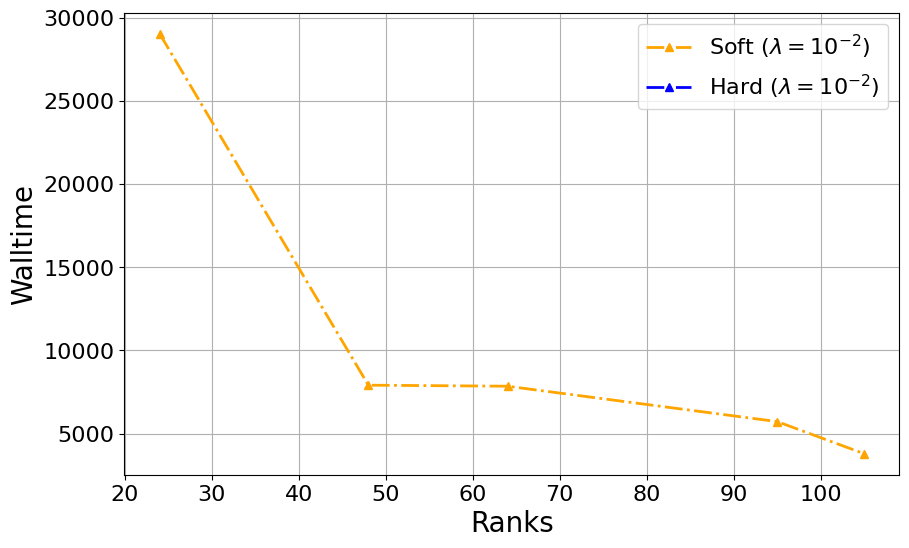

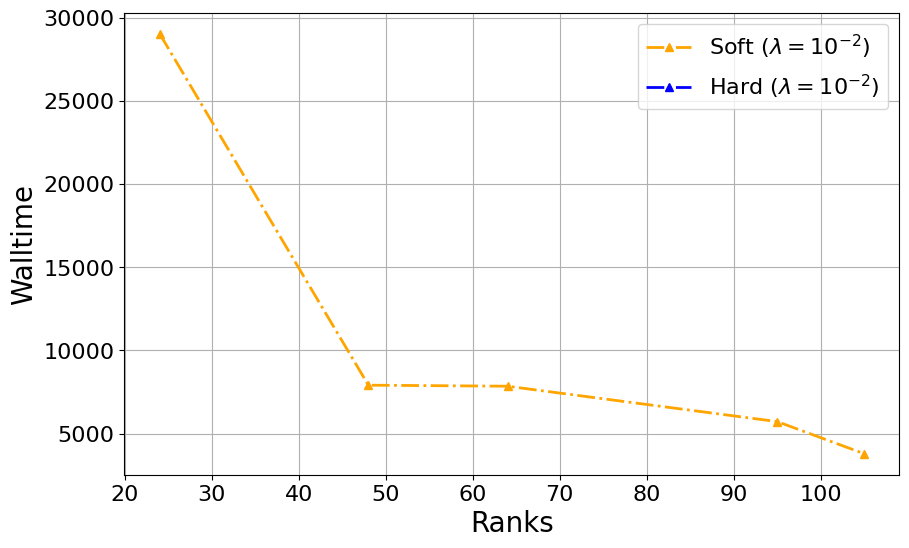

In [10]:
plot_hard_scaling(data)